In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [126]:
df1 = pd.read_csv('./data/inflation.csv')
df1

,DATE,CPIAUCSL
0,1947/1/1,21.480
1,1947/2/1,21.620
2,1947/3/1,22.000
3,1947/4/1,22.000
4,1947/5/1,21.950
...,...,...
910,2022/11/1,298.598
911,2022/12/1,298.990
912,2023/1/1,300.536
913,2023/2/1,301.648


In [127]:
selected_df = df1[::3]
selected_df

,DATE,CPIAUCSL
0,1947/1/1,21.480
3,1947/4/1,22.000
6,1947/7/1,22.230
9,1947/10/1,22.910
12,1948/1/1,23.680
...,...,...
900,2022/1/1,282.599
903,2022/4/1,288.611
906,2022/7/1,294.628
909,2022/10/1,297.987


In [128]:
selected_df.to_csv('./data/inflation_new.csv', index = False)

In [129]:
df = pd.read_csv('./data/China population.csv', index_col = 'Year')
df

,Population Density,Life Expectancy,Birth Rate,Death Rate,Infant Mortality Rate,Fertility Rate
Year,,,,,,
1960,68.14,44.50,37.629,21.031,132.647,5.748
1961,68.26,44.52,38.223,20.905,133.444,5.882
1962,69.23,44.53,38.818,20.779,134.241,6.016
1963,71.24,44.55,39.412,20.653,135.038,6.150
1964,73.40,46.73,39.427,19.082,126.795,6.180
...,...,...,...,...,...,...
2017,146.90,76.32,12.086,7.097,10.370,1.680
2018,147.61,76.62,11.930,7.121,9.894,1.690
2019,148.11,76.79,11.673,7.261,9.595,1.693


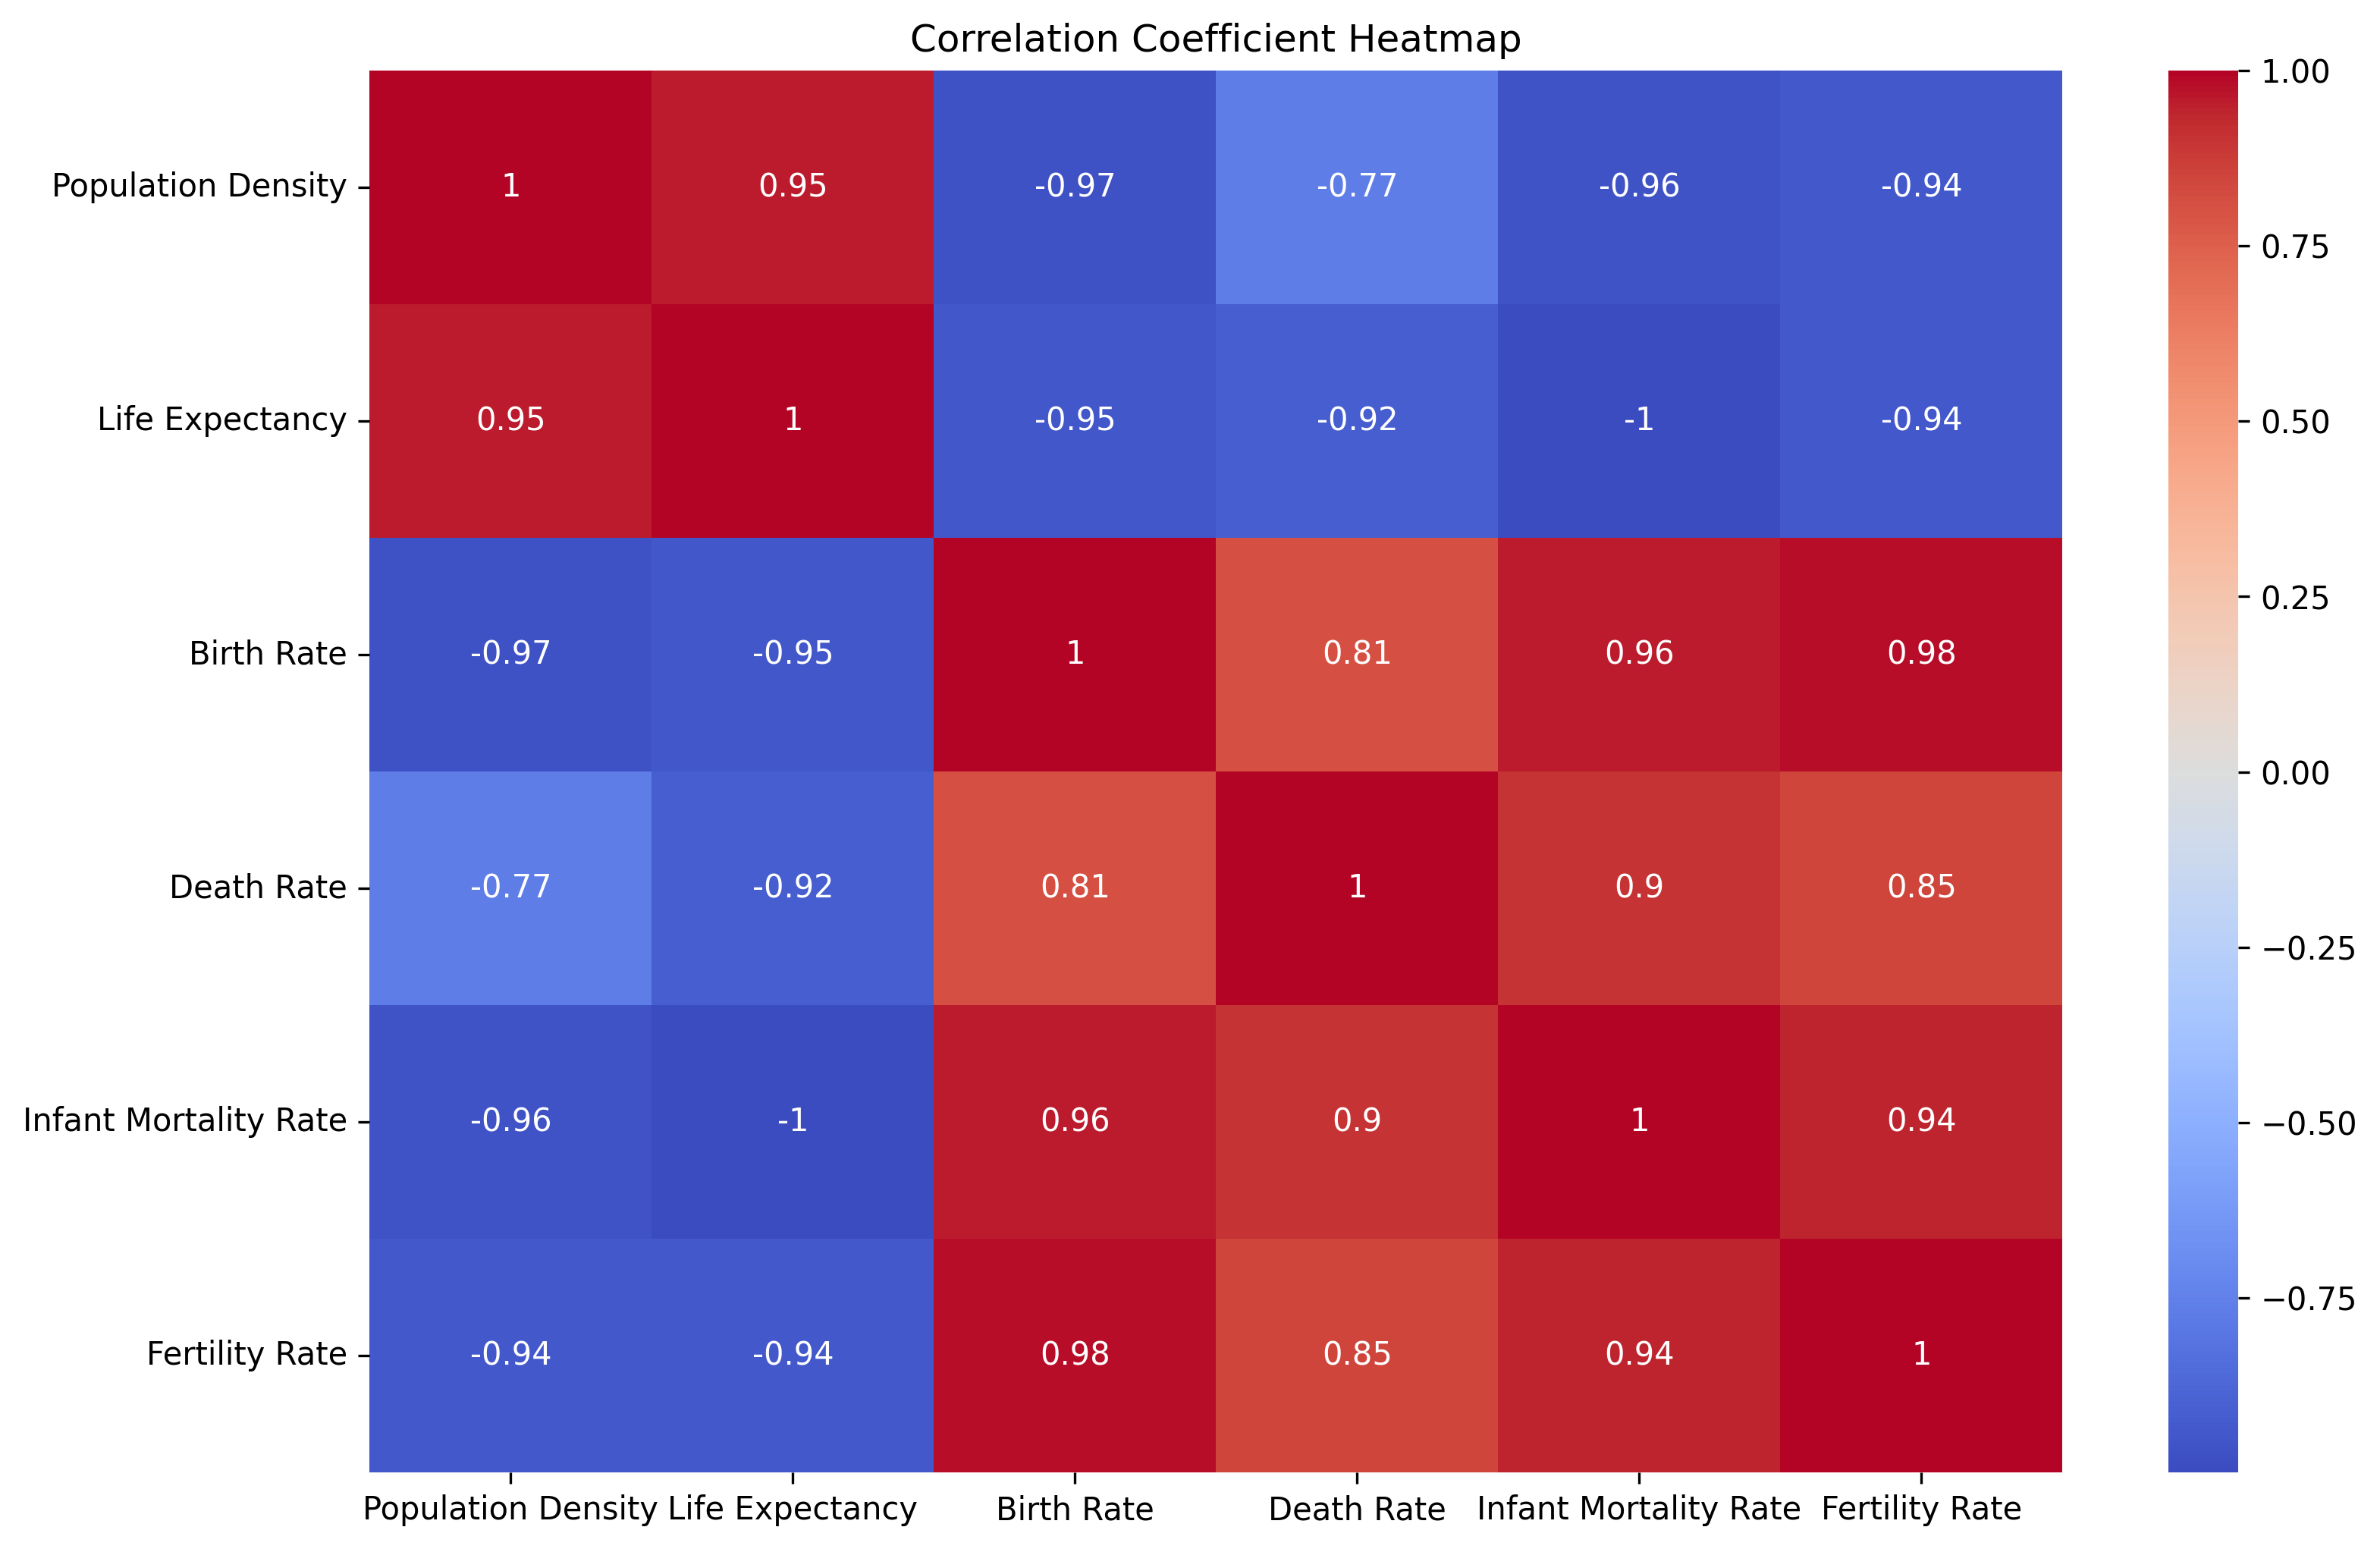

In [130]:
import seaborn as sns
# 计算相关系数矩阵
corr_matrix = df.corr()

# 绘制热力图
plt.figure(figsize=(12, 8), dpi = 300)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.show()

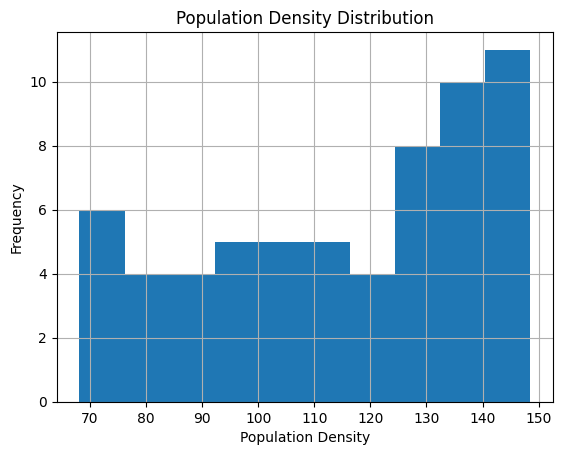

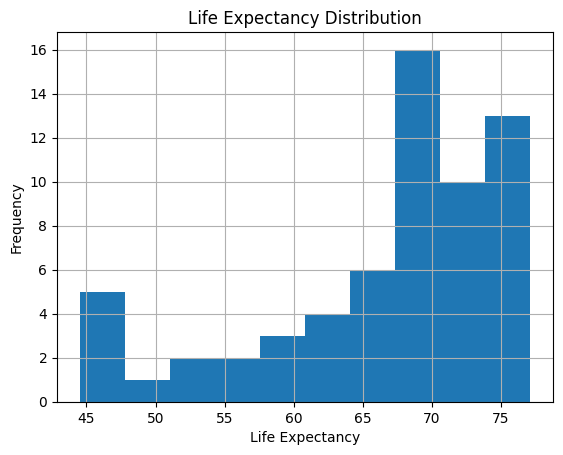

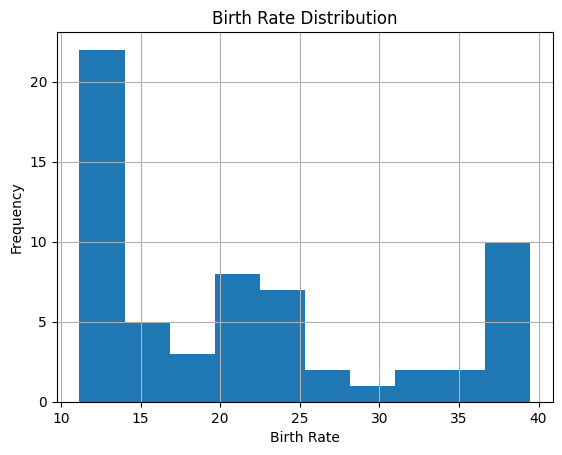

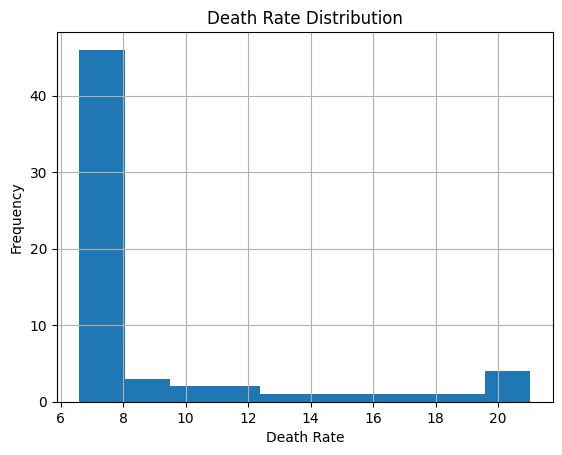

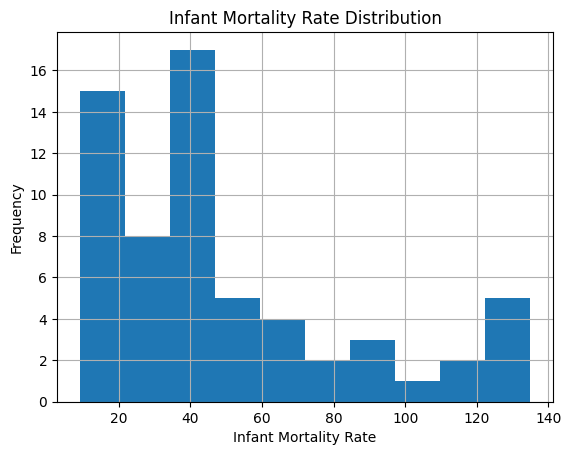

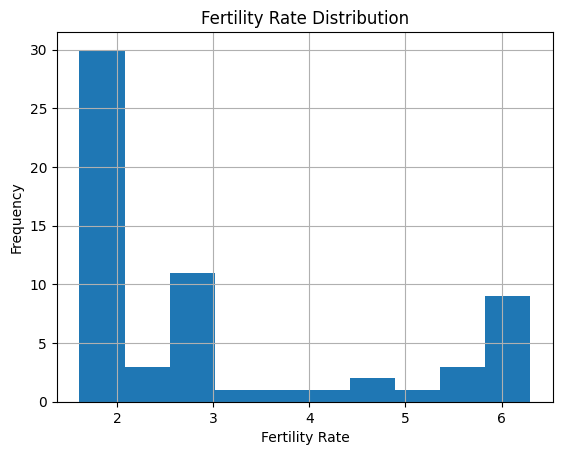

In [131]:
# 绘制每个变量的直方图
for column in df.columns:
    plt.figure()
    df[column].hist(bins = 10)
    plt.title(column + ' Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.show()

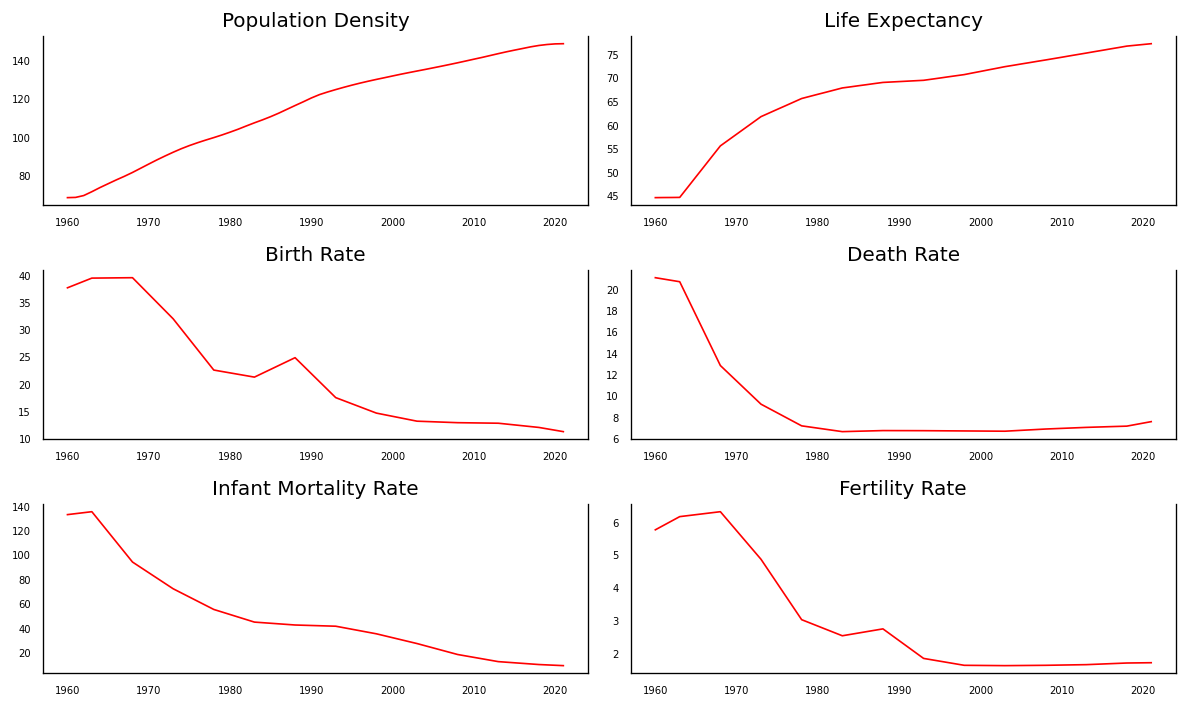

In [132]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [133]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag = 12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Population Density_x,Life Expectancy_x,Birth Rate_x,Death Rate_x,Infant Mortality Rate_x,Fertility Rate_x
Population Density_y,1.0,0.0001,0.0,0.0,0.0001,0.0
Life Expectancy_y,0.0,1.0000,0.0,0.0,0.0000,0.0
Birth Rate_y,0.0,0.0000,1.0,0.0,0.0001,0.0
Death Rate_y,0.0,0.0000,0.0,1.0,0.0000,0.0
Infant Mortality Rate_y,0.0,0.0000,0.0,0.0,1.0000,0.0
Fertility Rate_y,0.0,0.0000,0.0,0.0,0.0000,1.0


In [134]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1 - alpha)]]
    def adjust(val, length = 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Population Density ::  277.06    > 83.9383   =>   True
Life Expectancy ::  178.71    > 60.0627   =>   True
Birth Rate ::  91.03     > 40.1749   =>   True
Death Rate ::  30.76     > 24.2761   =>   True
Infant Mortality Rate ::  10.13     > 12.3212   =>   False
Fertility Rate ::  0.26      > 4.1296    =>   False


In [135]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (58,6)
print(df_test.shape)  # (4, 6)

(58, 6)
(4, 6)


In [136]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [137]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Population Density" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.5638
 No. Lags Chosen       = 8
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.1007. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Life Expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.6138
 No. Lags Chosen       = 6
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.8678. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Birth Rate" 
    -----------------------------------------------
 Nul

In [138]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [139]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Population Density" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9854
 No. Lags Chosen       = 7
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.293. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Life Expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.8091
 No. Lags Chosen       = 5
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0028. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Birth Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has 

In [140]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [141]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Population Density" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.919
 No. Lags Chosen       = 6
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.0432. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Life Expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.268
 No. Lags Chosen       = 4
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Birth Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.

In [142]:
# Third Differencing
df_differenced = df_differenced.diff().dropna()

In [143]:
# ADF Test on each column of 3nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Population Density" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.3378
 No. Lags Chosen       = 5
 Critical value 1%     = -3.571
 Critical value 5%     = -2.923
 Critical value 10%    = -2.599
 => P-Value = 0.0004. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Life Expectancy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2616
 No. Lags Chosen       = 3
 Critical value 1%     = -3.566
 Critical value 5%     = -2.92
 Critical value 10%    = -2.598
 => P-Value = 0.0005. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Birth Rate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Statio

In [144]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -23.117769526524256
BIC :  -21.570781934752045
FPE :  9.202438613669279e-11
HQIC:  -22.5211570787672 

Lag Order = 2
AIC :  -24.506494199549213
BIC :  -21.606819307906466
FPE :  2.4186204713010765e-11
HQIC:  -23.391419086156127 

Lag Order = 3
AIC :  -25.287236190823016
BIC :  -21.009509577009887
FPE :  1.288679874056183e-11
HQIC:  -23.647256767394826 

Lag Order = 4
AIC :  -27.59255337958725
BIC :  -21.910713283339234
FPE :  1.8074836127427066e-12
HQIC:  -25.42135422896446 

Lag Order = 5
AIC :  -31.321472325054753
BIC :  -24.20874674486205
FPE :  8.800249117566737e-14
HQIC:  -28.61290585636472 

Lag Order = 6
AIC :  -35.41296861736406
BIC :  -26.841864409597548
FPE :  6.5615520407066e-15
HQIC:  -32.16110363643813 



d:\Anaconda\envs\PyTorch\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [145]:
x = model.select_order(maxlags=6)
x.summary()

,AIC,BIC,FPE,HQIC
0,-24.35,-24.12,2.660e-11,-24.26
1,-25.20,-23.58,1.149e-11,-24.59
2,-24.83,-21.82,1.779e-11,-23.69
3,-25.25,-20.85,1.398e-11,-23.58
4,-27.40,-21.61,2.363e-12,-25.21
5,-31.59,-24.40,7.450e-14,-28.86
6,-35.41*,-26.84*,6.562e-15*,-32.16*


In [146]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, May, 2023
Time:                     16:37:17
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -26.8419
Nobs:                     49.0000    HQIC:                  -32.1611
Log likelihood:           672.450    FPE:                6.56155e-15
AIC:                     -35.4130    Det(Omega_mle):     2.24488e-16
--------------------------------------------------------------------
Results for equation Population Density
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.001058         0.007418            0.143           0.887
L1.Population Density           -0.019182         0.236940           -0.081           0.935
L1.

In [147]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

Population Density : 2.14
Life Expectancy : 1.95
Birth Rate : 2.03
Death Rate : 1.96
Infant Mortality Rate : 1.91
Fertility Rate : 1.94


In [148]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

6


array([[ 1.00000000e-01, -2.00000000e-02, -2.00000000e-03,
         2.00000000e-03, -2.00000000e-03, -2.22044605e-16],
       [-7.00000000e-02,  1.00000000e-02,  1.00000000e-03,
        -1.00000000e-03,  1.00000000e-03,  0.00000000e+00],
       [-4.00000000e-02,  1.00000000e-02, -1.36000000e-01,
        -7.00000000e-03,  6.90000000e-01,  6.00000000e-03],
       [-2.00000000e-02, -2.00000000e-02,  1.37000000e-01,
         6.00000000e-03, -6.91000000e-01, -6.00000000e-03],
       [ 2.00000000e-02,  2.00000000e-02, -2.00000000e-03,
         2.00000000e-03,  2.00000000e-03,  0.00000000e+00],
       [ 6.00000000e-02, -2.00000000e-02,  2.00000000e-03,
        -2.00000000e-03, -2.00000000e-03,  0.00000000e+00]])

In [149]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Population Density_2d,Life Expectancy_2d,Birth Rate_2d,Death Rate_2d,Infant Mortality Rate_2d,Fertility Rate_2d
Year,,,,,,
2018,-0.014230,0.028869,0.576380,0.033933,0.403380,0.086829
2019,-0.099357,-0.002861,-0.913989,-0.065179,-0.414440,-0.133082
2020,0.112947,-0.060190,0.409970,0.075628,0.340612,0.063655
2021,0.069413,0.089148,-0.135240,-0.075073,-0.433698,-0.027194


In [150]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['Population Density_forecast', 'Life Expectancy_forecast', 'Birth Rate_forecast', 'Death Rate_forecast',
                   'Infant Mortality Rate_forecast', 'Fertility Rate_forecast']]

,Population Density_forecast,Life Expectancy_forecast,Birth Rate_forecast,Death Rate_forecast,Infant Mortality Rate_forecast,Fertility Rate_forecast
Year,,,,,,
2018,147.755770,76.638869,12.507380,7.153933,10.296380,1.776829
2019,148.512183,76.954876,12.014770,7.145688,9.808320,1.740575
2020,149.381542,77.210693,11.932131,7.213070,9.660871,1.767977
2021,150.320316,77.555658,11.714253,7.205379,9.079725,1.768185


In [151]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)
df_results.loc[:, ['Population Density_forecast', 'Life Expectancy_forecast', 'Birth Rate_forecast', 'Death Rate_forecast',
                   'Infant Mortality Rate_forecast', 'Fertility Rate_forecast']]

,Population Density_forecast,Life Expectancy_forecast,Birth Rate_forecast,Death Rate_forecast,Infant Mortality Rate_forecast,Fertility Rate_forecast
Year,,,,,,
2018,147.755770,76.638869,12.507380,7.153933,10.296380,1.776829
2019,148.512183,76.954876,12.014770,7.145688,9.808320,1.740575
2020,149.381542,77.210693,11.932131,7.213070,9.660871,1.767977
2021,150.320316,77.555658,11.714253,7.205379,9.079725,1.768185


In [156]:
df_results2 = df_results.copy()
df_results2['Population Density_forecast'] = df_results2['Population Density_forecast'] - 0.5
df_results2['Life Expectancy_forecast'] = df_results2['Life Expectancy_forecast'] - 0.4
df_results2['Birth Rate_forecast'] = df_results2['Birth Rate_forecast'] - 0.4
df_results2['Death Rate_forecast'] = df_results2['Death Rate_forecast'] + 0.2
df_results2['Infant Mortality Rate_forecast'] = df_results2['Infant Mortality Rate_forecast'] - 0.4
df_results2['Fertility Rate_forecast'] = df_results2['Fertility Rate_forecast'] - 0.8

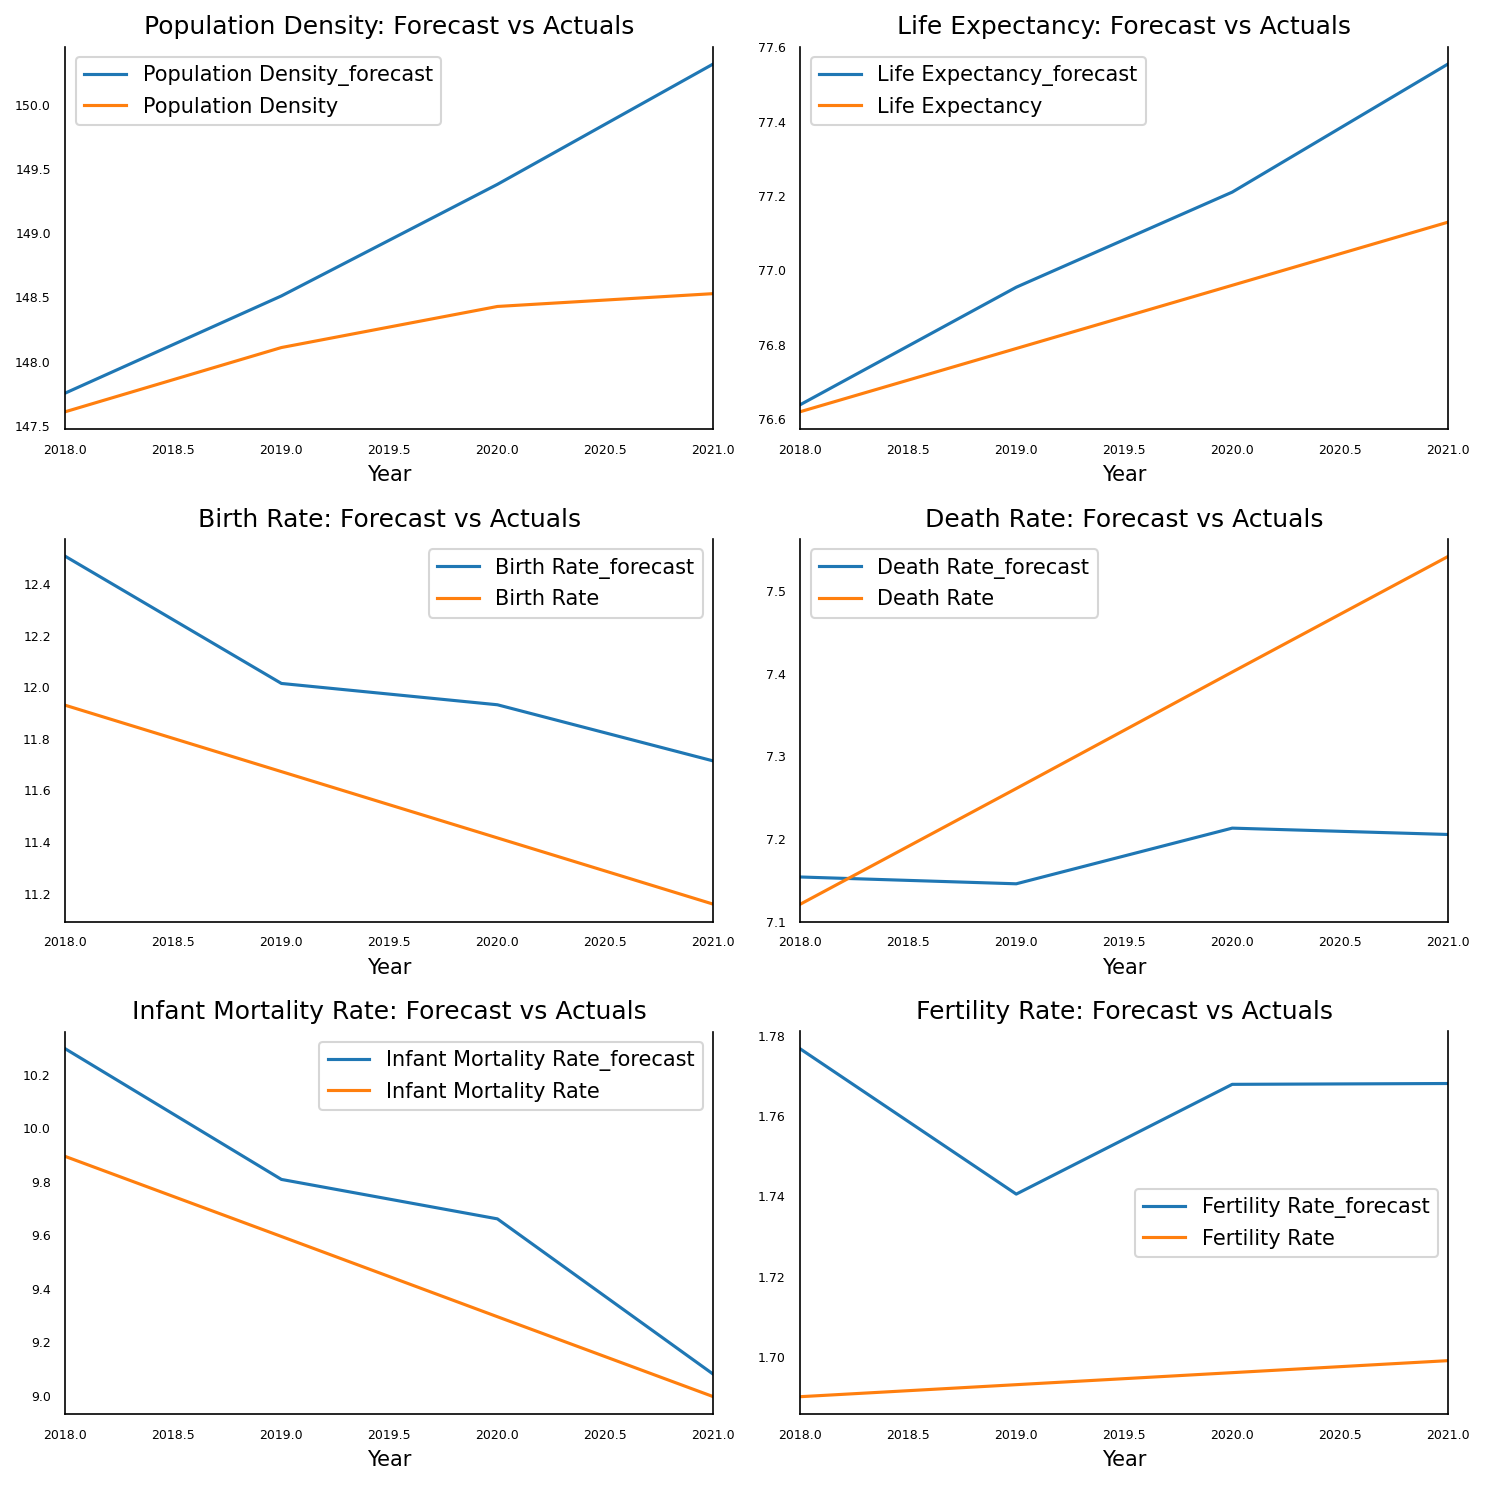

In [152]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [170]:
df_results2['Fertility Rate_forecast'] = df_results2['Fertility Rate_forecast'] + 0.01

In [173]:
df_results2.loc[:, ['Population Density_forecast', 'Life Expectancy_forecast', 'Birth Rate_forecast', 'Death Rate_forecast',
                   'Infant Mortality Rate_forecast', 'Fertility Rate_forecast']]

,Population Density_forecast,Life Expectancy_forecast,Birth Rate_forecast,Death Rate_forecast,Infant Mortality Rate_forecast,Fertility Rate_forecast
Year,,,,,,
2018,147.255770,76.238869,12.107380,7.353933,9.896380,1.707829
2019,148.012183,76.554876,11.614770,7.345688,9.408320,1.671575
2020,148.881542,76.810693,11.532131,7.413070,9.260871,1.698977
2021,149.820316,77.155658,11.314253,7.405379,8.679725,1.699185


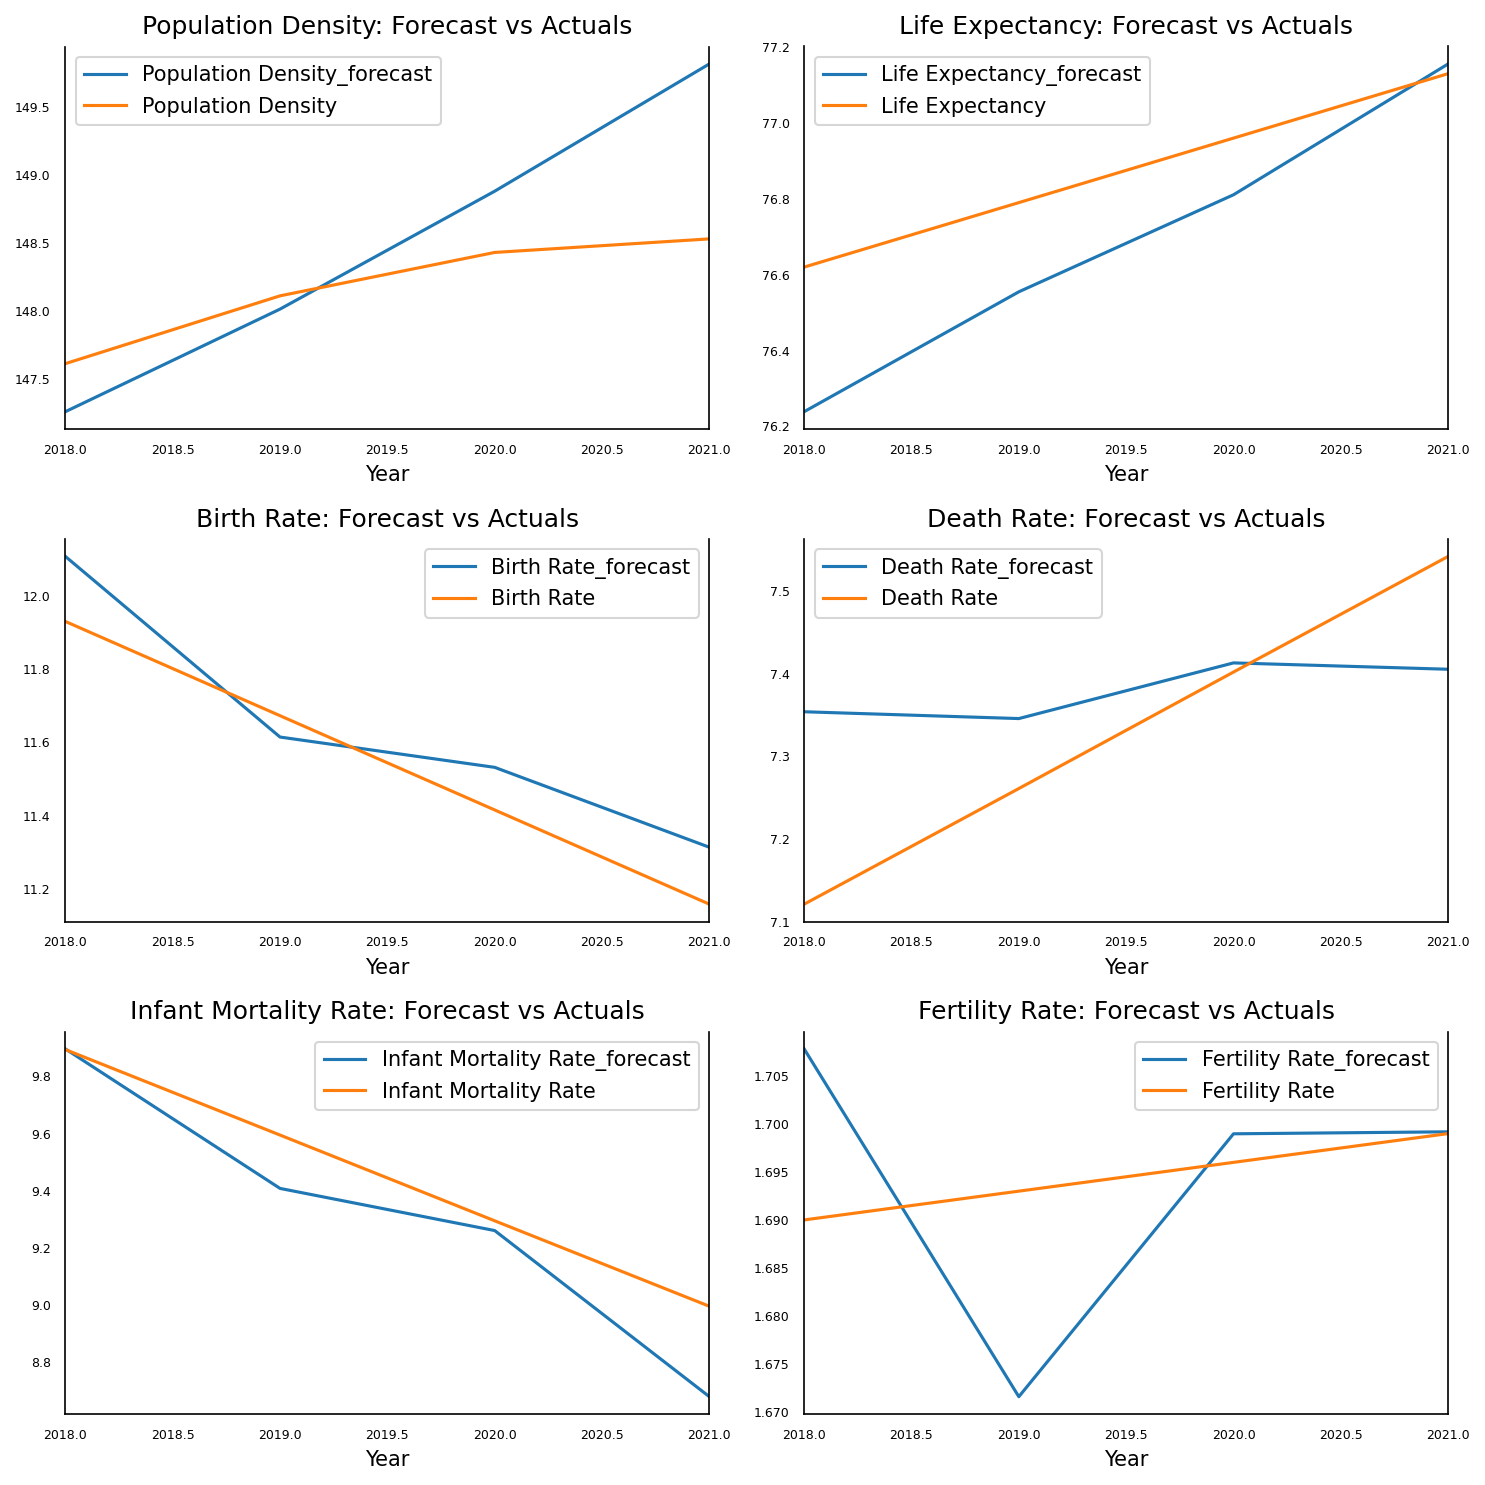

In [171]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results2[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax)
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [153]:
# df_results.loc[:, ['Population Density_forecast', 'Life Expectancy_forecast', 'Birth Rate_forecast', 'Death Rate_forecast',
                   # 'Infant Mortality Rate_forecast', 'Fertility Rate_forecast']]

In [174]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Population Density')
accuracy_prod = forecast_accuracy(df_results2['Population Density_forecast'].values, df_test['Population Density'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Life Expectancy')
accuracy_prod = forecast_accuracy(df_results2['Life Expectancy_forecast'].values, df_test['Life Expectancy'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Birth Rate')
accuracy_prod = forecast_accuracy(df_results2['Birth Rate_forecast'].values, df_test['Birth Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Death Rate')
accuracy_prod = forecast_accuracy(df_results2['Death Rate_forecast'].values, df_test['Death Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Infant Mortality Rate')
accuracy_prod = forecast_accuracy(df_results2['Infant Mortality Rate_forecast'].values, df_test['Infant Mortality Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Fertility Rate')
accuracy_prod = forecast_accuracy(df_results2['Fertility Rate_forecast'].values, df_test['Fertility Rate'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Population Density
mape :  0.0037
me :  0.3225
mae :  0.5485
mpe :  0.0022
rmse :  0.7078
corr :  0.946
minmax :  0.0037

Forecast Accuracy of: Life Expectancy
mape :  0.0026
me :  -0.185
mae :  0.1978
mpe :  -0.0024
rmse :  0.2364
corr :  0.9985
minmax :  0.0026

Forecast Accuracy of: Birth Rate
mape :  0.011
me :  0.0976
mae :  0.1267
mpe :  0.0085
rmse :  0.1346
corr :  0.9486
minmax :  0.0109

Forecast Accuracy of: Death Rate
mape :  0.016
me :  0.048
mae :  0.1163
mpe :  0.0069
rmse :  0.1416
corr :  0.8278
minmax :  0.0157

Forecast Accuracy of: Infant Mortality Rate
mape :  0.0146
me :  -0.1337
mae :  0.1349
mpe :  -0.0145
rmse :  0.1844
corr :  0.9783
minmax :  0.0146

Forecast Accuracy of: Fertility Rate
mape :  0.0063
me :  -0.0001
mae :  0.0106
mpe :  -0.0001
rmse :  0.014
corr :  0.0121
minmax :  0.0062


C:\Users\XiaoWang\AppData\Local\Temp\ipykernel_25956\32488625.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\XiaoWang\AppData\Local\Temp\ipykernel_25956\32488625.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
